In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from diffusion import DiffusionModel
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch

In [2]:
# # Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
# import torch
# wandb.login()
# api = wandb.Api()

# # Specify your entity, project, and sweep ID
# entity = "xingzhis"
# project = "dmae"
# sweep_id = 'n7krfbsz'

# # Fetch the sweep
# sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

# run_ids = [run.id for run in sweep.runs]
# run_id = 'ucvq4x2o'
# run = [run for run in sweep.runs if run.id == run_id][0]

# cfg = OmegaConf.create(run.config)
# folder_path = "../src/wandb/"
# folder_list = glob.glob(f"{folder_path}*{run.id}*")
# ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
# ckpt_path = ckpt_files[0]
# allloader, _, X, phate_coords, colors, dist, pp, _, _ = load_data(cfg, load_all=False)
# emb_dim = phate_coords.shape[1]
# data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
# data = np.load(data_path, allow_pickle=True)
# dist_std = np.std(data['dist'].flatten())
# model = make_model(cfg, X.shape[1], emb_dim, pp, dist_std, from_checkpoint=True, checkpoint_path=ckpt_path)
# model.eval()
# x_all = next(iter(allloader))['x']
# x_pred, z_pred = model(x_all)
# x_pred = x_pred.detach().cpu().numpy()
# z_pred = z_pred.detach().cpu().numpy()

In [3]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'u05futg7'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

run_id = 'xsj3odwl'
run = [run for run in sweep.runs if run.id == run_id][0]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [4]:
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]

In [5]:
diffusionmodel = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    data_size=10, 
    time_embedding_size=cfg.time_embedding_size,
    layer_widths=cfg.layer_widths,
    dropout=cfg.dropout,
    batch_norm=cfg.batch_norm,
    num_steps=cfg.num_steps,
    learning_rate=cfg.lr,
    weight_decay=cfg.weight_decay,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [6]:
dat = np.load('../dm_data/eb_all_10.npz')

In [7]:
# train_mask = data['is_train']
# data_train = data['data'][train_mask]
# color_train = data['colors'][train_mask]

In [8]:
# data_pred = x_pred[~train_mask]
# latent_pred = z_pred[~train_mask]
train_mask = dat['train_mask']
with torch.no_grad():
    generated_latent = diffusionmodel.generate_samples((~train_mask).sum())

In [9]:
data_latent = np.load(cfg.path + cfg.data)
data_latent_train = data_latent['data'][data_latent['train_mask']]
mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)

In [10]:
generated_latent = generated_latent * std_ + mean_

In [11]:
# with torch.no_grad():
#     generated_ambient = model.decode(generated_latent)

In [12]:
# generated = generated_ambient.detach().cpu().numpy()

In [13]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [14]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
latent_gen = generated_latent.detach().cpu().numpy()

In [16]:
latent_test = data_latent['data'][~data_latent['train_mask']]

In [18]:
latent_test.mean(axis=0)

array([-2.0513875 , -1.3463763 , -2.7189796 ,  2.865738  , -1.9128035 ,
       -0.7072906 ,  1.9343247 ,  3.0472    ,  0.48421434, -0.47793153],
      dtype=float32)

In [19]:
latent_train = data_latent['data'][data_latent['train_mask']]

In [39]:
def compute_w2(gen, tru):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    n = latent_test.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

In [42]:
std = latent_train.std()

In [43]:
noises = np.arange(1, 10) * 0.1
w2s = []
for noise in noises:
    noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
    w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
    w2s.append(w2)

In [44]:
res = np.array([noises, w2s]).T

In [45]:
w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()

In [46]:
w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

In [47]:
w_rand

array(41.756752, dtype=float32)

In [48]:
w_gen

array(38.35653, dtype=float32)

Text(0, 0.5, 'w2')

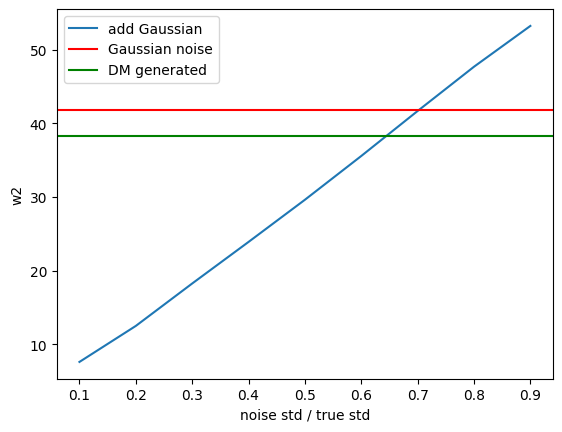

In [49]:
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1], label='add Gaussian')
ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
ax.axhline(y=w_gen, color='g', linestyle='-', label='DM generated')
ax.legend()
ax.set_xlabel('noise std / true std')
ax.set_ylabel('w2')

In [60]:
# go back to ambient space

In [63]:
run_id = 'ucvq4x2o'
run = [run for run in sweep.runs if run.id == run_id][0]
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
allloader, _, X, phate_coords, colors, dist, pp = load_data(cfg, load_all=True)
emb_dim = phate_coords.shape[1]
data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path, allow_pickle=True)
dist_std = np.std(data['dist'].flatten())
model = make_model(cfg, X.shape[1], emb_dim, pp, dist_std, from_checkpoint=True, checkpoint_path=ckpt_path)
model.eval()
# x_all = next(iter(allloader))['x']
# x_pred, z_pred = model(x_all)
# x_pred = x_pred.detach().cpu().numpy()
# z_pred = z_pred.detach().cpu().numpy()
# np.savez('../dm_data/eb_all_10.npz', data=z_pred, train_mask=data['is_train'])

IndexError: list index out of range